# Outflow Strength Calculations

In this notebook, I go over how outflow and inflow strengths are calculated for a single snapshot. These methods have been incorporated in paramovie.py.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import yt
from glob import glob
from astropy.table import Table
from yt.units import kpc,km,s,cm
import astropy
import siman

# Working Functions

In [11]:
def galaxy_center(filename):
    track = Table.read('/astro/simulations/FOGGIE/'+filename[26:-14]+'/halo_track', format='ascii') 
    track.sort('col1')

    # load the snapshot
    ds = yt.load(filename)
    zsnap = ds.get_parameter('CosmologyCurrentRedshift')
    
    # interpolate the center from the track
    centerx = np.interp(zsnap, track['col1'], track['col2']) 
    centery = np.interp(zsnap, track['col1'], track['col3']) 
    centerz = 0.5 * ( np.interp(zsnap, track['col1'], track['col4']) + np.interp(zsnap, track['col1'], track['col7'])) 

    # approximation of center using jason's method
    nearcen = [centerx, centery+20. / 143886., centerz]
    
    # searches sphere w/ 50 kpc radius and sets center at point with highest density
    sph = ds.sphere(nearcen, (50,'kpc'))
    best = np.where(np.max(sph['dark_matter_density'])==sph['dark_matter_density'])[0][0]
    center = [sph['x'][best],sph['y'][best],sph['z'][best]]

    return ds,center

In [12]:
# Calculates the mass outflow with given radial flux and mass
def calculate_mass_flow(flux,mass,step):
    happy = np.sum(np.multiply(flux,mass)/(step*kpc))
    return happy.in_units('Msun/yr')

In [31]:
# Calculates the mass outflow
def calculate_mass_flow_profile(spcyl,lower=0,upper=100,step=5,pos='above',flow='out',vmeth='cyl'):
    if vmeth == 'cyl':
        # Allows us to call the cylindrically derived flux
        met = 'cyl_flux'
        # cyl method: radius refers to the distance above the disk of the galaxy
        radius = spcyl['height'].in_units('kpc')
    elif vmeth == 'rad':
        # Allows us to call the radially derived flux
        met='radial_flux'
        # sph method: radius refers to the distance from the center of the galaxy
        radius = spcyl['radius'].in_units('kpc')
    
    # The list of heights over which the calculations are done
    height_list = np.arange(lower,upper+2*step,step)*kpc
    # Loads the position of each point with respect to the galactic center
    position = spcyl['center_position']
    # Loads the velocity flux using the method specified
    vel_flux = spcyl[met].in_units('km/s')
    # Loads the cell mass of each element
    mass = spcyl['cell_mass'].in_units('Msun')
    
    # Differentiates outflows and inflows by comparing the sign of the velocity flux.
    # It is important to note that, when using the cyl method, you must reverse the 
    #     'out' and 'in' keywords when looking below the disk of the galaxy, due to
    #     the fact that the signs will be reversed.
    #
    # For the CYL method:
    # Inflows: v < 0 above the disk, v > 0 below the disk
    # Outflows: v > 0 above the disk, v < 0 below the disk
    #
    # For the RAD method:
    # Inflows: v < 0 everywhere
    # Outflows: v > 0 everywhere
    
    if flow =='out':
        f = vel_flux > 0
    elif flow == 'in':
        f = vel_flux < 0
    elif flow == 'all':
        f = all
    else:
        print "error: flow not specified"
        return None

    # Specifies where calculations are performed with respect to the disk.
    # Again, it is important to note that, when using the cyl method, you will
    #     need to reverse the signs for inflows and outflows.
    if pos == 'above':
        p = np.dot(L,position)>
    elif pos == 'below':
        p = np.dot(L,position)<0
    elif pos == 'all':
        p = all
    else:
        print "error: position not specified"
        return None

    outflow = []
    for i in range(len(height_list)-1):
        # Includes only points within a specified height range that follow
        #     the flow and position criteria specified.
        x = np.where((radius > height_list[i])&
                     (radius < height_list[i+1])&
                     (f)&
                     (p))[0]
        # Adds the calculated outflow rate for the current shell to outflow
        outflow.append(calculate_mass_flow(spcyl[met][x],spcyl['cell_mass'][x],step))
    return height_list[:-1],outflow

# Loading Data

First, the simulation snapshot we'll be using needs to be loaded. There are directory names and angular momentum vectors for each of the 5 simulations that have been found using the methods followed in edgefinder. In order to load the simulation, make sure the only mid, L, and Lx variables that are not commented are the ones for the simulation you plan on analyzing.

mid: the name of the main simulation directory

L: the angular momentum vector calculated using the method found in edgefinder

Lx: a vector that is orthogonal to the angular momentum vector calculated using the edgefinder method

Once you have selected a simulation, this creates a list of all of the snapshots (DD????) for this particular simulation.

In [26]:
# This is the base path to the directory containing the simulation snapshots
base = '/astro/simulations/FOGGIE/halo_008508/'

# 100% Feedback
#mid = 'nref10_track_2'
#L = [-0.37645994,  0.50723191,  0.77523784]
#Lx = [ 0.,          0.83679869, -0.54751068]

# 30% Feedback
mid = 'nref10_track_lowfdbk_1'
L = [-0.56197719,  0.56376017,  0.60527358]
Lx = [ 0.,          0.73175552, -0.6815672 ]

# 10% Feedback
#mid = 'nref10_track_lowfdbk_2'
#L = [-0.48868346,  0.6016812,   0.63179761]
#Lx = [ 0., 0.72415556, -0.68963666]

# 3% Feedback
#mid = 'nref10_track_lowfdbk_3'
#L = [-0.28229104, 0.68215233, 0.67452203]
#Lx = [ 0., 0.7031187, -0.71107249]

# 1% Feedback
#mid = 'nref10_track_lowfdbk_4'
#L = [-0.37819875, 0.57817821, 0.72296312]
#Lx = [ 0., 0.78097012, -0.62456839]

full_dir = base+mid+'/DD????/DD????'
all_dir = glob(full_dir)     # a list of each simulation snapshot found in the main simulation directory

For our purposes, we will only look at one snapshot of our simulation.

The galaxy_center function loads the snapshot and determines the center of the galaxy. We are then able to find the bulk velocity of the galaxy, which will used when calculating the rate of outflows.

In [27]:
# Uses the file below as a test case
file_name = all_dir[50]

# Finds center of galaxy, based on dark matter density
ds,center = galaxy_center(file_name)

# Finds the bulk velocity of the galaxy
bsp = ds.sphere(center, (15,'kpc'))
bulk_v = bsp.quantities.bulk_velocity()
gx = bulk_v[0]
gy = bulk_v[1]
gz = bulk_v[2]

yt : [INFO     ] 2017-08-16 09:54:36,449 Parameters: current_time              = 306.816562811
yt : [INFO     ] 2017-08-16 09:54:36,451 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2017-08-16 09:54:36,453 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-08-16 09:54:36,454 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-08-16 09:54:36,456 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-08-16 09:54:36,457 Parameters: current_redshift          = 0.84711265424
yt : [INFO     ] 2017-08-16 09:54:36,458 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-08-16 09:54:36,459 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-08-16 09:54:36,460 Parameters: hubble_constant           = 0.695
Parsing Hierarchy : 100%|██████████| 2424/2424 [00:00<00:00, 5130.17it/s]
yt : [INFO     ] 2017-08-16 09:54:37,140 Gathering a field list (this may take a moment.)


# Two Methods of Calculating Velocity Flux

### Method 1: Cylindrical Symmetry

This method calculates the velocity component of the material that is perpendicular to the galactic disk.

First, the cyl_flux and center_position keywords are added to the field list of our current data set.

The center_position keyword defines the poisition of each point with respect to the center of the galaxy, as opposed to the corner of the simulation. This is mostly used to determine where the particle is located with respect to the galactic disk.

The cyl_flux keyword is the velocity component of the material that is moving in the direction perpendicular to the disk of the galaxy. It is calculated by subtracting the bulk velocity from the velocity of material at every point, then dotting this velocity with the angular momentum vector.

Because the calculations are performed in this way, it is important to pay close attention to where the material being analyzed is with respect to the disk. Material that is above and moving away from the galaxy has a positive velocity. Material below and moving towards the galaxy also has a positive velocity since it is also moving in the same direction as the angular momentum vector. Be sure to remember this when comparing material above and below galactic disk.

In [28]:
# Defines the position of a point with respect to the center of the galaxy
def _centpos(field,data):
    xpos = data['x'] - center[0]
    ypos = data['y'] - center[1]
    zpos = data['z'] - center[2]
    pos = np.array([xpos,ypos,zpos])
    return pos
# Add this field to the loaded dataset
ds.add_field('center_position',force_override=True, function=_centpos,units='', take_log=False,display_name='Position from Galaxy')

# Calculates the velocity flux
def _vflux(field,data):
    # Define x, y, and z velocity components
    x = data['x-velocity'].in_units('km/s')
    y = data['y-velocity'].in_units('km/s')
    z = data['z-velocity'].in_units('km/s')
    # Take dot product of bulk velocity and angular momentum vector
    bx = np.multiply(bulk_v[0],L[0])
    by = np.multiply(bulk_v[1],L[1])
    bz = np.multiply(bulk_v[2],L[2])
    leng = bx+by+bz
    # Subtract the bulk velocity from the velocity of the material at each point
    nx = x-leng
    ny = y-leng
    nz = z-leng
    # Take dot product of new velocity and angular momentum vector
    Lxx = np.multiply(nx,L[0])
    Ly = np.multiply(ny,L[1])
    Lz = np.multiply(nz,L[2])
    return Lxx+Ly+Lz

# Add the cyl_flux field to our loaded dataset
ds.add_field('cyl_flux',force_override=True, function=_vflux,units='code_velocity', take_log=False,display_name='Velocity Flux')

Here, the mass flow rate is actually calculated. For more details on how this is done, you can refer to where this function is saved. The results are plotted below.

It is important to note that, when using the cylindrical method, the sign of the velocity below the galaxy is flipped from that above the galaxy

In [29]:
# Define a sphere of data around the center with a radius of 100 kpc
sp = ds.sphere(center,(100,'kpc'))
# Calculate the mass outflow rate above the disk of the galaxy and save the height and outflow rate list to happy
mass_flow = calculate_mass_flow_profile(sp,0,100,10)

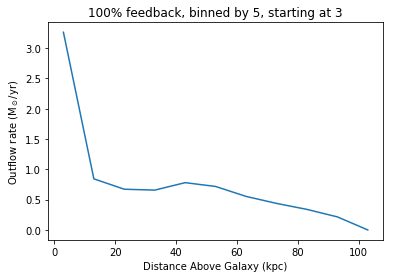

In [15]:
# Plot the outflow rate as a function of distance above the galactic disk
plt.plot(mass_flow[0],mass_flow[1])
plt.title('100% feedback, binned by 5, starting at 3')
plt.xlabel('Distance Above Galaxy (kpc)')
plt.ylabel(r'Outflow rate (M$_\odot$/yr)')
# Optional, if you want to save this plot
#plt.savefig('outflow_rate/fdbk100_bin5.png')
plt.show()

### Method 2: Radial Symmetry

This method finds the velocity component of the material that is moving in the direction radial to the center of the galaxy

Here, the center_position keyword is used once again, along with the radial_flux keyword.

In this case, the flux is calculated by dotting the velocity of the material at a certain point with the point's position relative to the center of the galaxy, in order to determine the velocity component moving radially away or towards the galaxy.

Here, because we are not using the angular momentum vector, the sign of material moving away from the galaxy is always positive and material moving towards the galaxy is always negative, unlike calculations done using cylindrical symmetry.

In [16]:
# Defines the position of a point with respect to the center of the galaxy
def _centpos(field,data):
    xpos = data['x'] - center[0]
    ypos = data['y'] - center[1]
    zpos = data['z'] - center[2]
    pos = np.array([xpos,ypos,zpos])
    return pos
# Add this field to the loaded dataset
ds.add_field('center_position',force_override=True, function=_centpos,units='', take_log=False,display_name='Position from Galaxy')

def _rv(field,data):
    pos = data['center_position']
    # Normalize the position of each point relative to the galactic center
    pos = np.array([pos[:,i]/np.linalg.norm(pos[:,i]) for i in range(len(pos[0]))])
    # Take the dot product of the galaxy's bulk velocity with its position
    #     relative to the galactic center.
    # gx, gy, and gz are the bulk velocity calculated earlier
    vbx = np.multiply(gx,pos[:,0])
    vby = np.multiply(gy,pos[:,1])
    vbz = np.multiply(gz,pos[:,2])
    vb = vbx+vby+vbz
    # Subtract the component of the bulk velocity in the radial direction from the
    #    x, y, and z velocity of the material in the galaxy
    vx = data['x-velocity']-vb
    vy = data['y-velocity']-vb
    vz = data['z-velocity']-vb
    # Take the dot product of the new velocity with the position of the material with
    #     respect to the galactic center in order to find the velocity moving radially
    #     to or from the center of the galaxy.
    rvx = np.multiply(vx,pos[:,0])
    rvy = np.multiply(vy,pos[:,1])
    rvz = np.multiply(vz,pos[:,2])
    return rvx+rvy+rvz
# Add this field to the loaded dataset
ds.add_field('radial_flux',force_override=True, function=_rv,units='code_velocity', take_log=False,display_name='Radial Velocity')

By using the vmeth keyword, you can change the method of calculation from the cylindrical method to the radial method, as shown below. The results for the radial method are also plotted below.

In [21]:
sp = ds.sphere(center,(100,'kpc'))
rad_mass_flow = calculate_mass_flow_profile(sp,3,100,10,vmeth='rad')

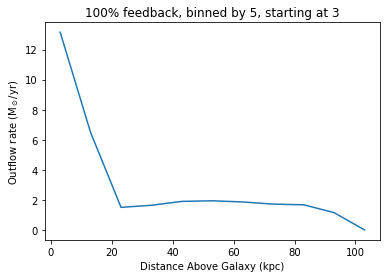

In [22]:
plt.plot(rad_mass_flow[0],rad_mass_flow[1])
plt.title('100% feedback, binned by 5, starting at 3')
plt.xlabel('Distance Above Galaxy (kpc)')
plt.ylabel(r'Outflow rate (M$_\odot$/yr)')
#plt.savefig('outflow_rate/fdbk100_bin5.png')
plt.show()

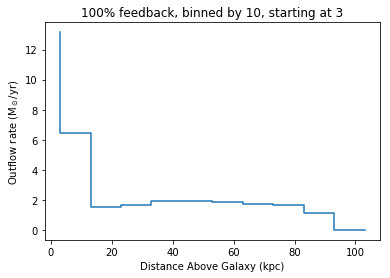

In [24]:
plt.step(rad_mass_flow[0],rad_mass_flow[1])
plt.title('100% feedback, binned by 10, starting at 3')
plt.xlabel('Distance Above Galaxy (kpc)')
plt.ylabel(r'Outflow rate (M$_\odot$/yr)')
#plt.savefig('outflow_rate/fdbk100_bin10.png')
plt.show()